In [289]:
import json

from Bio import SeqIO
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [181]:
np.random.seed(42)
tf.set_random_seed(42)

### Data Loading

In [4]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

In [5]:
raw_data = list(SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"))

In [6]:
raw_data[0]

SeqRecord(seq=Seq('MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGS...SLP', SingleLetterAlphabet()), id='Q9H400', name='Q9H400', description='Q9H400 Cell.membrane-M test', dbxrefs=[])

In [31]:
loc_id_labels = {}
mem_id_labels = {}
seq_list = []

for record in raw_data:
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    desc_split = description.split(" ")
    # Use ID for indexing
    ID = desc_split[0]
    # Split label into Q10 subcellular location and Q2 membrane bound vs water soluble
    label = desc_split[1]
    loc_label = label[:len(label)-2]
    mem_label = label[-1]
    # Ignore ambiguous cytoplasm-nucleus labels
    if loc_label == "Cytoplasm-Nucleus":
        continue
    loc_id_labels[ID] = loc_label
    mem_id_labels[ID] = mem_label

In [32]:
seq_df = pd.DataFrame(seq_list)
seq_df.describe(percentiles=[.91, .95, .99])

,0
count,12704.000000
mean,418.507793
std,234.958061
min,40.000000
50%,389.000000
91%,781.000000
95%,873.000000
99%,988.970000
max,1024.000000


In [33]:
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

In [34]:
pd.Series([val for (_, val) in loc_id_labels.items()]).value_counts()

Nucleus                  3488
Cytoplasm                2156
Extracellular            1918
Mitochondrion            1491
Cell.membrane            1173
Endoplasmic.reticulum     820
Plastid                   743
Golgi.apparatus           332
Lysosome/Vacuole          298
Peroxisome                151
dtype: int64

In [95]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}

id_dict_mem = {
    'M': 0,
    'S': 1,
    'U': 2
}

reverse_id_dict = {value: key for key, value in id_dict.items()}
reverse_id_dict_mem = {value: key for key, value in id_dict_mem.items()}

In [37]:
def gen_df(df, label_list, arrays):
    seq_ids = list(arrays.keys())
    loc_labels = []
    mem_labels = []
    for seq_id in seq_ids:
        if seq_id in loc_id_labels:
            d = arrays[seq_id].item()['avg']
            append_df = pd.DataFrame(d)
            loc_labels.append(loc_id_labels[seq_id])
            mem_labels.append(mem_id_labels[seq_id])
            df = df.append(append_df.transpose(), ignore_index=True)
    return df, loc_labels, mem_labels

train_df, train_loc_labels, train_mem_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_loc_labels, valid_mem_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_loc_labels, test_mem_labels = gen_df(pd.DataFrame(), [], test_arrays)

In [38]:
pd.Series(test_loc_labels).value_counts()

Nucleus                  675
Cytoplasm                424
Extracellular            377
Mitochondrion            299
Cell.membrane            224
Endoplasmic.reticulum    162
Plastid                  147
Golgi.apparatus           63
Lysosome/Vacuole          57
Peroxisome                28
dtype: int64

In [39]:
pd.Series(test_mem_labels).value_counts()

S    899
U    891
M    666
dtype: int64

In [40]:
pd.Series(train_mem_labels).value_counts()

S    3375
U    3373
M    2351
dtype: int64

In [41]:
pd.Series(valid_mem_labels).value_counts()

U    369
S    353
M    267
dtype: int64

In [42]:
reverse_id_dict = {value: key for key, value in id_dict.items()}

### Logistic Regression (Q2)

In [43]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_mem_labels = np.array(train_mem_labels + valid_mem_labels)

In [44]:
train_valid_df = train_valid_df[train_valid_mem_labels != 'U']
train_valid_mem_labels = train_valid_mem_labels[train_valid_mem_labels != 'U']

In [45]:
test_mem_labels_q2 = np.array(test_mem_labels)
test_mem_df = test_df[test_mem_labels_q2 != 'U']
test_mem_labels_q2 = test_mem_labels_q2[test_mem_labels_q2 != 'U']

In [46]:
train_valid_df.shape

(6346, 768)

In [47]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_mem_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
clf.score(train_valid_df, train_valid_mem_labels)

0.9322407815947054

In [49]:
clf.score(test_mem_df, test_mem_labels_q2)

0.8715654952076677

In [139]:
logreg_q2_test_preds = clf.predict(test_mem_df)

### Keras DNN (Q2)

In [ ]:
from keras.callbacks import EarlyStopping

In [98]:
print(type(train_df))
print(type(train_mem_labels))

<class 'pandas.core.frame.DataFrame'>
<class 'list'>


In [117]:
train_mem_labels_q2 = np.array(train_mem_labels)
valid_mem_labels_q2 = np.array(valid_mem_labels)
test_mem_labels_q2 = np.array(test_mem_labels)

train_df_q2 = train_df[train_mem_labels_q2 != 'U']
valid_df_q2 = valid_df[valid_mem_labels_q2 != 'U']
test_df_q2 = test_df[test_mem_labels_q2 != 'U']

train_mem_labels_q2 = train_mem_labels_q2[train_mem_labels_q2 != 'U']
valid_mem_labels_q2 = valid_mem_labels_q2[valid_mem_labels_q2 != 'U']
test_mem_labels_q2 = test_mem_labels_q2[test_mem_labels_q2 != 'U']

train_lab_mem = [id_dict_mem[label] for label in train_mem_labels_q2]
valid_lab_mem = [id_dict_mem[label] for label in valid_mem_labels_q2]
test_lab_mem = [id_dict_mem[label] for label in test_mem_labels_q2]

In [129]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [130]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [131]:
history = model.fit(train_df_q2, to_categorical(train_lab_mem), 
          validation_data=(valid_df_q2, to_categorical(valid_lab_mem)),
          epochs=500, batch_size=64, callbacks=keras_callbacks)

Train on 5726 samples, validate on 620 samples
Epoch 1/500
5726/5726 [==============================] - 1s 218us/step - loss: 0.4200 - acc: 0.8188 - val_loss: 0.3079 - val_acc: 0.8879
Epoch 2/500
5726/5726 [==============================] - 0s 42us/step - loss: 0.3219 - acc: 0.8699 - val_loss: 0.2835 - val_acc: 0.8887
Epoch 3/500
5726/5726 [==============================] - 0s 46us/step - loss: 0.2996 - acc: 0.8780 - val_loss: 0.2749 - val_acc: 0.8919
Epoch 4/500
5726/5726 [==============================] - 0s 45us/step - loss: 0.2810 - acc: 0.8851 - val_loss: 0.2771 - val_acc: 0.8847
Epoch 5/500
5726/5726 [==============================] - 0s 42us/step - loss: 0.2710 - acc: 0.8909 - val_loss: 0.2690 - val_acc: 0.8831
Epoch 6/500
5726/5726 [==============================] - 0s 43us/step - loss: 0.2507 - acc: 0.8978 - val_loss: 0.2586 - val_acc: 0.8863
Epoch 7/500
5726/5726 [==============================] - 0s 42us/step - loss: 0.2503 - acc: 0.8987 - val_loss: 0.2892 - val_acc: 0.8750


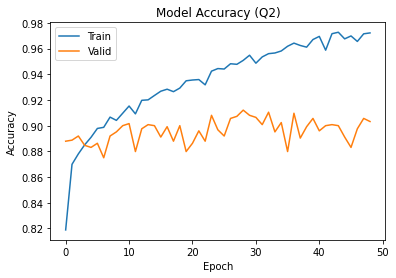

In [156]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy (Q2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [133]:
model.evaluate(test_df_q2, to_categorical(test_lab_mem))

1565/1565 [==============================] - 0s 32us/step


[0.5105548801132666, 0.896485623079367]

In [134]:
dnn_q2_test_probs = model.predict(test_df_q2)
dnn_q2_test_preds_num = np.argmax(dnn_q2_test_probs, axis=1)
dnn_q2_test_preds = [reverse_id_dict_mem[pred] for pred in dnn_q2_test_preds_num]

### Logistic Regression (Q10)

In [157]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_loc_labels = train_loc_labels + valid_loc_labels

In [160]:
print(train_valid_df.shape)
print(len(train_loc_labels))
print(len(valid_loc_labels))

(10088, 768)
9099
989


In [161]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_loc_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [162]:
clf.score(train_valid_df, train_valid_loc_labels)

0.8073949246629659

In [163]:
clf.score(test_df, test_loc_labels)

0.6624592833876222

In [164]:
logreg_test_preds = clf.predict(test_df)

### Keras DNN (Q10)

In [166]:
train_lab = [id_dict[label] for label in train_loc_labels]
valid_lab = [id_dict[label] for label in valid_loc_labels]
test_lab = [id_dict[label] for label in test_loc_labels]

In [167]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [168]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=50, mode='min', min_delta=0.0001)
]

In [169]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=500, batch_size=64, callbacks=keras_callbacks)

Train on 9099 samples, validate on 989 samples
Epoch 1/500
9099/9099 [==============================] - 3s 287us/step - loss: 1.4444 - acc: 0.5073 - val_loss: 1.1819 - val_acc: 0.5703
Epoch 2/500
9099/9099 [==============================] - 0s 42us/step - loss: 1.1526 - acc: 0.6034 - val_loss: 1.0890 - val_acc: 0.6208
Epoch 3/500
9099/9099 [==============================] - 0s 43us/step - loss: 1.0605 - acc: 0.6315 - val_loss: 1.0296 - val_acc: 0.6421
Epoch 4/500
9099/9099 [==============================] - 0s 43us/step - loss: 1.0136 - acc: 0.6486 - val_loss: 0.9917 - val_acc: 0.6461
Epoch 5/500
9099/9099 [==============================] - 1s 64us/step - loss: 0.9648 - acc: 0.6610 - val_loss: 1.0043 - val_acc: 0.6471
Epoch 6/500
9099/9099 [==============================] - 0s 40us/step - loss: 0.9360 - acc: 0.6775 - val_loss: 0.9661 - val_acc: 0.6552
Epoch 7/500
9099/9099 [==============================] - 0s 40us/step - loss: 0.9069 - acc: 0.6829 - val_loss: 0.9856 - val_acc: 0.6502


9099/9099 [==============================] - 0s 46us/step - loss: 0.4394 - acc: 0.8460 - val_loss: 1.0020 - val_acc: 0.6987
Epoch 61/500
9099/9099 [==============================] - 0s 37us/step - loss: 0.4313 - acc: 0.8525 - val_loss: 0.9951 - val_acc: 0.7139
Epoch 62/500
9099/9099 [==============================] - 0s 40us/step - loss: 0.4197 - acc: 0.8608 - val_loss: 1.0578 - val_acc: 0.6835
Epoch 63/500
9099/9099 [==============================] - 0s 39us/step - loss: 0.4163 - acc: 0.8621 - val_loss: 1.0042 - val_acc: 0.7027
Epoch 64/500
9099/9099 [==============================] - 0s 47us/step - loss: 0.4088 - acc: 0.8648 - val_loss: 1.0829 - val_acc: 0.6795
Epoch 65/500
9099/9099 [==============================] - 0s 42us/step - loss: 0.4164 - acc: 0.8582 - val_loss: 1.0376 - val_acc: 0.6896
Epoch 66/500
9099/9099 [==============================] - 0s 41us/step - loss: 0.4105 - acc: 0.8623 - val_loss: 1.0483 - val_acc: 0.6906
Epoch 67/500
9099/9099 [==============================

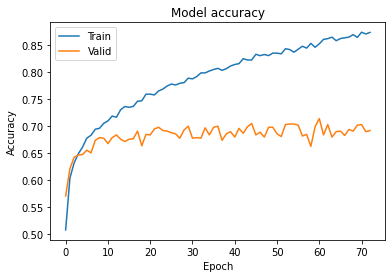

In [170]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [171]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 78us/step


[1.383821040100694, 0.6445439737472162]

In [172]:
dnn_test_probs = model.predict(test_df)
dnn_test_preds_num = np.argmax(dnn_test_probs, axis=1)
dnn_test_preds = [reverse_id_dict[pred] for pred in dnn_test_preds_num]

### Metrics

In [136]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

#### Logistic Regression (Q2)

In [142]:
print("Logistic Regression Classification Report (Q2)\n")
print(classification_report(test_mem_labels_q2, logreg_q2_test_preds))

Logistic Regression Classification Report (Q2)

              precision    recall  f1-score   support

           M       0.87      0.82      0.85       666
           S       0.87      0.91      0.89       899

   micro avg       0.87      0.87      0.87      1565
   macro avg       0.87      0.87      0.87      1565
weighted avg       0.87      0.87      0.87      1565



In [143]:
logreg_cm = confusion_matrix(test_mem_labels_q2, logreg_q2_test_preds)

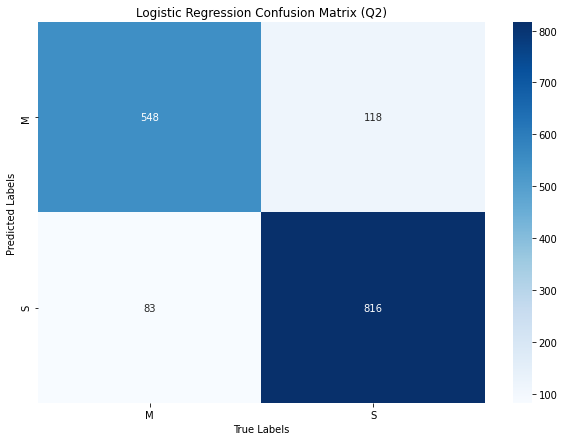

In [148]:
df_cm = pd.DataFrame(logreg_cm, index=sorted(id_dict_mem.keys())[:2], columns=sorted(id_dict_mem.keys())[:2])
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Logistic Regression Confusion Matrix (Q2)")
plt.show(fig)

#### Logistic Regression (Q10)

In [173]:
print("Logistic Regression Classification Report (Q10)\n")
print(classification_report(test_loc_labels, logreg_test_preds))

Logistic Regression Classification Report (Q10)

                       precision    recall  f1-score   support

        Cell.membrane       0.63      0.65      0.64       224
            Cytoplasm       0.53      0.41      0.46       424
Endoplasmic.reticulum       0.53      0.51      0.52       162
        Extracellular       0.88      0.89      0.89       377
      Golgi.apparatus       0.34      0.21      0.26        63
     Lysosome/Vacuole       0.30      0.18      0.22        57
        Mitochondrion       0.70      0.68      0.69       299
              Nucleus       0.66      0.82      0.73       675
           Peroxisome       0.38      0.11      0.17        28
              Plastid       0.73      0.72      0.73       147

            micro avg       0.66      0.66      0.66      2456
            macro avg       0.57      0.52      0.53      2456
         weighted avg       0.65      0.66      0.65      2456



In [175]:
logreg_cm = confusion_matrix(test_loc_labels, logreg_test_preds)

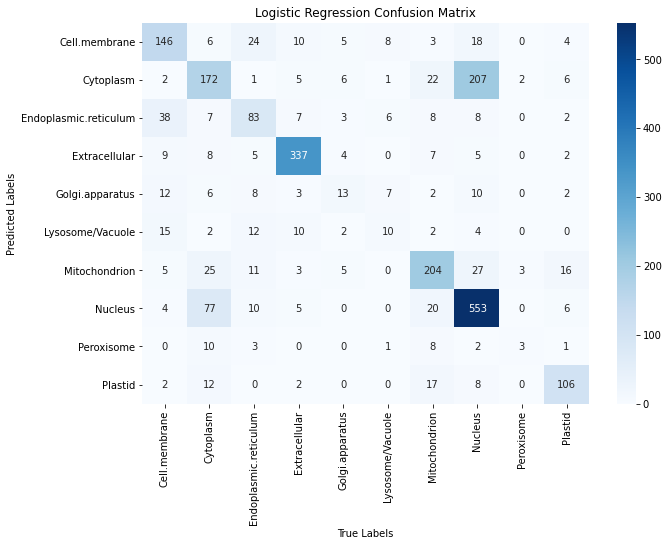

In [176]:
df_cm = pd.DataFrame(logreg_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Logistic Regression Confusion Matrix")
plt.show(fig)

#### Keras DNN (Q2)

In [155]:
print("Keras DNN Classification Report Q2\n")
print(classification_report(test_mem_labels_q2, dnn_q2_test_preds))

Keras DNN Classification Report Q2

              precision    recall  f1-score   support

           M       0.90      0.84      0.87       666
           S       0.89      0.93      0.91       899

   micro avg       0.89      0.89      0.89      1565
   macro avg       0.90      0.89      0.89      1565
weighted avg       0.89      0.89      0.89      1565



In [152]:
dnn_cm = confusion_matrix(test_mem_labels_q2, dnn_q2_test_preds)

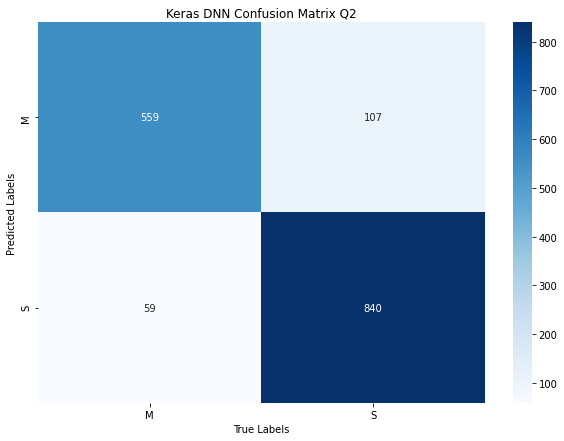

In [154]:
df_cm = pd.DataFrame(dnn_cm, index=sorted(id_dict_mem.keys())[:2], columns=sorted(id_dict_mem.keys())[:2])
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Keras DNN Confusion Matrix Q2")
plt.show(fig)

#### Keras DNN (Q10)

In [177]:
print("Keras DNN Classification Report Q10\n")
print(classification_report(test_loc_labels, dnn_test_preds))

Keras DNN Classification Report Q10

                       precision    recall  f1-score   support

        Cell.membrane       0.61      0.63      0.62       224
            Cytoplasm       0.54      0.40      0.46       424
Endoplasmic.reticulum       0.57      0.45      0.50       162
        Extracellular       0.85      0.86      0.85       377
      Golgi.apparatus       0.39      0.22      0.28        63
     Lysosome/Vacuole       0.34      0.33      0.34        57
        Mitochondrion       0.75      0.61      0.67       299
              Nucleus       0.63      0.83      0.72       675
           Peroxisome       0.14      0.07      0.10        28
              Plastid       0.61      0.69      0.65       147

            micro avg       0.64      0.64      0.64      2456
            macro avg       0.54      0.51      0.52      2456
         weighted avg       0.64      0.64      0.63      2456



In [178]:
dnn_cm = confusion_matrix(test_loc_labels, dnn_test_preds)

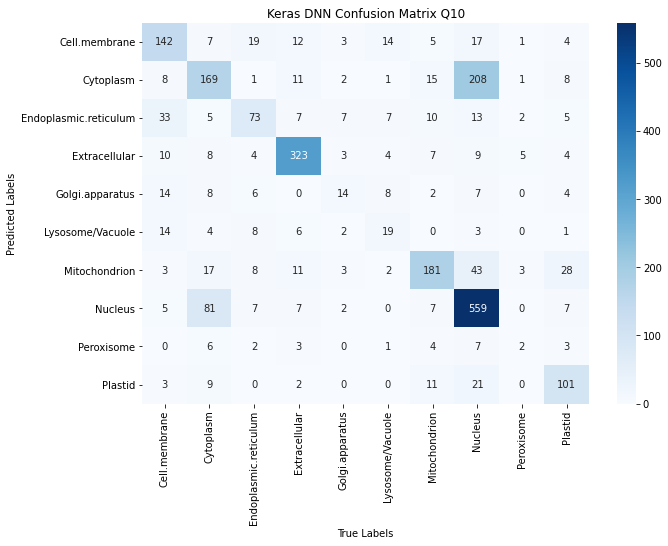

In [179]:
df_cm = pd.DataFrame(dnn_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Keras DNN Confusion Matrix Q10")
plt.show(fig)

#### Multitask

In [197]:
# Create arrays for all labels (loc=q10, mem=q2)
train_loc_labels_mt = np.array(train_loc_labels)
valid_loc_labels_mt = np.array(valid_loc_labels)
test_loc_labels_mt = np.array(test_loc_labels)

train_mem_labels_mt = np.array(train_mem_labels)
valid_mem_labels_mt = np.array(valid_mem_labels)
test_mem_labels_mt = np.array(test_mem_labels)

# Modify features to exclude unknown q2 labels
train_df_mt = train_df[train_mem_labels_mt != 'U']
valid_df_mt = valid_df[valid_mem_labels_mt != 'U']
test_df_mt = test_df[test_mem_labels_mt != 'U']

# Modify labels to exclude unknown q2 labels
train_loc_labels_mt = train_loc_labels_mt[train_mem_labels_mt != 'U']
valid_loc_labels_mt = valid_loc_labels_mt[valid_mem_labels_mt != 'U']
test_loc_labels_mt = test_loc_labels_mt[test_mem_labels_mt != 'U']

train_mem_labels_mt = train_mem_labels_mt[train_mem_labels_mt != 'U']
valid_mem_labels_mt = valid_mem_labels_mt[valid_mem_labels_mt != 'U']
test_mem_labels_mt = test_mem_labels_mt[test_mem_labels_mt != 'U']

# Create new label lists with ints instead of strings
train_lab_loc = [id_dict[label] for label in train_loc_labels_mt]
valid_lab_loc = [id_dict[label] for label in valid_loc_labels_mt]
test_lab_loc = [id_dict[label] for label in test_loc_labels_mt]

train_lab_mem = [id_dict_mem[label] for label in train_mem_labels_mt]
valid_lab_mem = [id_dict_mem[label] for label in valid_mem_labels_mt]
test_lab_mem = [id_dict_mem[label] for label in test_mem_labels_mt]

In [198]:
print(len(valid_lab_mem))
print(len(valid_lab_loc))

620
620


In [251]:
keras.backend.clear_session()

In [252]:
visible = keras.Input(shape=(768,))
h1 = Dense(32, activation='relu')(visible)
h2 = Dense(32, activation='relu')(h1)

output_q10 = Dense(10, activation='softmax', name='q10')(h2)
output_q2 = Dense(2, activation='sigmoid', name='q2')(h2)

In [253]:
model = keras.Model(inputs=visible, outputs=[output_q10, output_q2])
model.compile(loss=['categorical_crossentropy', 'binary_crossentropy'],
              optimizer='adam', metrics=['accuracy', 'accuracy'])

# model.compile(loss=['categorical_crossentropy', 'binary_crossentropy'],
#               optimizer='adam', metrics=['accuracy', 'accuracy'], 
#               loss_weights = [1e-1, 1])

In [254]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [255]:
history = model.fit(train_df_mt,
                    [to_categorical(train_lab_loc), to_categorical(train_lab_mem)],
                    validation_data=(valid_df_mt, [to_categorical(valid_lab_loc), to_categorical(valid_lab_mem)]),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Train on 5726 samples, validate on 620 samples
Epoch 1/200
5726/5726 [==============================] - 1s 134us/step - loss: 2.1619 - q10_loss: 1.6124 - q2_loss: 0.5494 - q10_acc: 0.5010 - q10_acc_1: 0.5010 - q2_acc: 0.7280 - q2_acc_1: 0.7280 - val_loss: 1.6194 - val_q10_loss: 1.2168 - val_q2_loss: 0.4026 - val_q10_acc: 0.6113 - val_q10_acc_1: 0.6113 - val_q2_acc: 0.8484 - val_q2_acc_1: 0.8484
Epoch 2/200
5726/5726 [==============================] - 0s 43us/step - loss: 1.5246 - q10_loss: 1.1624 - q2_loss: 0.3622 - q10_acc: 0.6352 - q10_acc_1: 0.6352 - q2_acc: 0.8616 - q2_acc_1: 0.8616 - val_loss: 1.3749 - val_q10_loss: 1.0551 - val_q2_loss: 0.3198 - val_q10_acc: 0.6677 - val_q10_acc_1: 0.6677 - val_q2_acc: 0.8669 - val_q2_acc_1: 0.8669
Epoch 3/200
5726/5726 [==============================] - 0s 53us/step - loss: 1.3688 - q10_loss: 1.0528 - q2_loss: 0.3160 - q10_acc: 0.6626 - q10_acc_1: 0.6626 - q2_acc: 0.8722 - q2_acc_1: 0.8722 - val_loss: 1.3448 - val_q10_loss: 1.0513 - val_q2_loss:

5726/5726 [==============================] - 0s 51us/step - loss: 0.8083 - q10_loss: 0.6140 - q2_loss: 0.1943 - q10_acc: 0.8048 - q10_acc_1: 0.8048 - q2_acc: 0.9209 - q2_acc_1: 0.9209 - val_loss: 1.0427 - val_q10_loss: 0.8145 - val_q2_loss: 0.2282 - val_q10_acc: 0.7306 - val_q10_acc_1: 0.7306 - val_q2_acc: 0.9065 - val_q2_acc_1: 0.9065
Epoch 25/200
5726/5726 [==============================] - 0s 66us/step - loss: 0.7984 - q10_loss: 0.6107 - q2_loss: 0.1876 - q10_acc: 0.8007 - q10_acc_1: 0.8007 - q2_acc: 0.9212 - q2_acc_1: 0.9212 - val_loss: 1.0538 - val_q10_loss: 0.8152 - val_q2_loss: 0.2386 - val_q10_acc: 0.7339 - val_q10_acc_1: 0.7339 - val_q2_acc: 0.8992 - val_q2_acc_1: 0.8992
Epoch 26/200
5726/5726 [==============================] - 0s 68us/step - loss: 0.7696 - q10_loss: 0.5851 - q2_loss: 0.1845 - q10_acc: 0.8159 - q10_acc_1: 0.8159 - q2_acc: 0.9253 - q2_acc_1: 0.9253 - val_loss: 1.0441 - val_q10_loss: 0.8113 - val_q2_loss: 0.2329 - val_q10_acc: 0.7500 - val_q10_acc_1: 0.7500 - va

5726/5726 [==============================] - 0s 41us/step - loss: 0.5681 - q10_loss: 0.4394 - q2_loss: 0.1287 - q10_acc: 0.8631 - q10_acc_1: 0.8631 - q2_acc: 0.9499 - q2_acc_1: 0.9499 - val_loss: 1.1118 - val_q10_loss: 0.8619 - val_q2_loss: 0.2499 - val_q10_acc: 0.7484 - val_q10_acc_1: 0.7484 - val_q2_acc: 0.9016 - val_q2_acc_1: 0.9016
Epoch 48/200
5726/5726 [==============================] - 0s 41us/step - loss: 0.5820 - q10_loss: 0.4459 - q2_loss: 0.1361 - q10_acc: 0.8624 - q10_acc_1: 0.8624 - q2_acc: 0.9466 - q2_acc_1: 0.9466 - val_loss: 1.1122 - val_q10_loss: 0.8556 - val_q2_loss: 0.2566 - val_q10_acc: 0.7339 - val_q10_acc_1: 0.7339 - val_q2_acc: 0.9016 - val_q2_acc_1: 0.9016
Epoch 49/200
5726/5726 [==============================] - 0s 39us/step - loss: 0.5665 - q10_loss: 0.4375 - q2_loss: 0.1289 - q10_acc: 0.8606 - q10_acc_1: 0.8606 - q2_acc: 0.9486 - q2_acc_1: 0.9486 - val_loss: 1.1345 - val_q10_loss: 0.8805 - val_q2_loss: 0.2541 - val_q10_acc: 0.7565 - val_q10_acc_1: 0.7565 - va

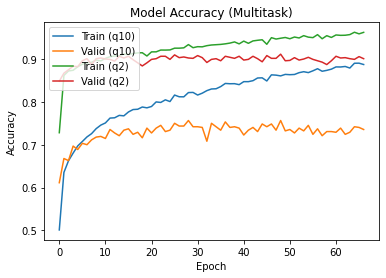

In [256]:
plt.plot(history.history['q10_acc'])
plt.plot(history.history['val_q10_acc'])
plt.plot(history.history['q2_acc'])
plt.plot(history.history['val_q2_acc'])
plt.title('Model Accuracy (Multitask)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

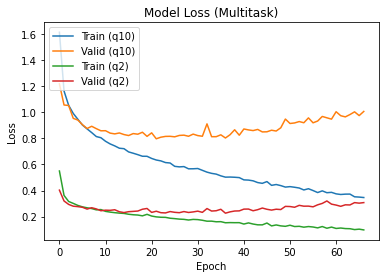

In [257]:
plt.plot(history.history['q10_loss'])
plt.plot(history.history['val_q10_loss'])
plt.plot(history.history['q2_loss'])
plt.plot(history.history['val_q2_loss'])
plt.title('Model Loss (Multitask)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

In [258]:
model.evaluate(test_df_mt, [to_categorical(test_lab_loc), to_categorical(test_lab_mem)])

1565/1565 [==============================] - 0s 23us/step


[1.614086850839682,
 1.175295683713005,
 0.4387911707258072,
 0.7073482429638457,
 0.7073482429638457,
 0.8814696482956981,
 0.8814696482956981]

#### Multitask (w/ Q2 including Unknown)

In [268]:
# Create arrays for all labels (loc=q10, mem=q3)
train_loc_labels_mtu = np.array(train_loc_labels)
valid_loc_labels_mtu = np.array(valid_loc_labels)
test_loc_labels_mtu = np.array(test_loc_labels)

train_mem_labels_mtu = np.array(train_mem_labels)
valid_mem_labels_mtu = np.array(valid_mem_labels)
test_mem_labels_mtu = np.array(test_mem_labels)

# Create new label lists with ints instead of strings
train_lab_loc_u = [id_dict[label] for label in train_loc_labels_mtu]
valid_lab_loc_u = [id_dict[label] for label in valid_loc_labels_mtu]
test_lab_loc_u = [id_dict[label] for label in test_loc_labels_mtu]

train_lab_mem_u = [id_dict_mem[label] for label in train_mem_labels_mtu]
valid_lab_mem_u = [id_dict_mem[label] for label in valid_mem_labels_mtu]
test_lab_mem_u = [id_dict_mem[label] for label in test_mem_labels_mtu]

In [291]:
keras.backend.clear_session()

visible = keras.Input(shape=(768,))
h1 = Dense(32, activation='relu')(visible)
h2 = Dropout(0.25)(h1)
h3 = BatchNormalization()(h2)

output_q10 = Dense(10, activation='softmax', name='q10')(h3)
output_q3 = Dense(3, activation='softmax', name='q3')(h3)

model = keras.Model(inputs=visible, outputs=[output_q10, output_q3])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer='adam', metrics=['accuracy', 'accuracy'])

In [292]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [293]:
history = model.fit(train_df,
                    [to_categorical(train_lab_loc_u), to_categorical(train_lab_mem_u)],
                    validation_data=(valid_df, [to_categorical(valid_lab_loc_u), to_categorical(valid_lab_mem_u)]),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x168e02fd0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 5693394880


Train on 9099 samples, validate on 989 samples
Epoch 1/200
9099/9099 [==============================] - 3s 301us/step - loss: 2.5300 - q10_loss: 1.6615 - q3_loss: 0.8684 - q10_acc: 0.4509 - q10_acc_1: 0.4509 - q3_acc: 0.5806 - q3_acc_1: 0.5806 - val_loss: 2.1578 - val_q10_loss: 1.4725 - val_q3_loss: 0.6852 - val_q10_acc: 0.5612 - val_q10_acc_1: 0.5612 - val_q3_acc: 0.6886 - val_q3_acc_1: 0.6886
Epoch 2/200
9099/9099 [==============================] - 1s 72us/step - loss: 1.9985 - q10_loss: 1.3005 - q3_loss: 0.6980 - q10_acc: 0.5612 - q10_acc_1: 0.5612 - q3_acc: 0.6885 - q3_acc_1: 0.6885 - val_loss: 1.7841 - val_q10_loss: 1.1498 - val_q3_loss: 0.6343 - val_q10_acc: 0.5945 - val_q10_acc_1: 0.5945 - val_q3_acc: 0.7088 - val_q3_acc_1: 0.7088
Epoch 3/200
9099/9099 [==============================] - 1s 67us/step - loss: 1.8764 - q10_loss: 1.2111 - q3_loss: 0.6654 - q10_acc: 0.5829 - q10_acc_1: 0.5829 - q3_acc: 0.7007 - q3_acc_1: 0.7007 - val_loss: 1.7299 - val_q10_loss: 1.0968 - val_q3_loss:

9099/9099 [==============================] - 1s 58us/step - loss: 1.5094 - q10_loss: 0.9451 - q3_loss: 0.5643 - q10_acc: 0.6724 - q10_acc_1: 0.6724 - q3_acc: 0.7576 - q3_acc_1: 0.7576 - val_loss: 1.5795 - val_q10_loss: 0.9811 - val_q3_loss: 0.5984 - val_q10_acc: 0.6512 - val_q10_acc_1: 0.6512 - val_q3_acc: 0.7422 - val_q3_acc_1: 0.7422
Epoch 25/200
9099/9099 [==============================] - 0s 54us/step - loss: 1.4872 - q10_loss: 0.9352 - q3_loss: 0.5520 - q10_acc: 0.6759 - q10_acc_1: 0.6759 - q3_acc: 0.7674 - q3_acc_1: 0.7674 - val_loss: 1.5445 - val_q10_loss: 0.9560 - val_q3_loss: 0.5885 - val_q10_acc: 0.6663 - val_q10_acc_1: 0.6663 - val_q3_acc: 0.7432 - val_q3_acc_1: 0.7432
Epoch 26/200
9099/9099 [==============================] - 1s 70us/step - loss: 1.4976 - q10_loss: 0.9412 - q3_loss: 0.5564 - q10_acc: 0.6678 - q10_acc_1: 0.6678 - q3_acc: 0.7594 - q3_acc_1: 0.7594 - val_loss: 1.6114 - val_q10_loss: 1.0055 - val_q3_loss: 0.6058 - val_q10_acc: 0.6593 - val_q10_acc_1: 0.6593 - va

9099/9099 [==============================] - 1s 55us/step - loss: 1.4737 - q10_loss: 0.9302 - q3_loss: 0.5435 - q10_acc: 0.6738 - q10_acc_1: 0.6738 - q3_acc: 0.7626 - q3_acc_1: 0.7626 - val_loss: 1.5927 - val_q10_loss: 1.0044 - val_q3_loss: 0.5884 - val_q10_acc: 0.6724 - val_q10_acc_1: 0.6724 - val_q3_acc: 0.7503 - val_q3_acc_1: 0.7503
Epoch 48/200
9099/9099 [==============================] - 0s 50us/step - loss: 1.4250 - q10_loss: 0.8980 - q3_loss: 0.5270 - q10_acc: 0.6837 - q10_acc_1: 0.6837 - q3_acc: 0.7681 - q3_acc_1: 0.7681 - val_loss: 1.5876 - val_q10_loss: 0.9911 - val_q3_loss: 0.5965 - val_q10_acc: 0.6532 - val_q10_acc_1: 0.6532 - val_q3_acc: 0.7503 - val_q3_acc_1: 0.7503
Epoch 49/200
9099/9099 [==============================] - 0s 49us/step - loss: 1.4534 - q10_loss: 0.9155 - q3_loss: 0.5379 - q10_acc: 0.6805 - q10_acc_1: 0.6805 - q3_acc: 0.7631 - q3_acc_1: 0.7631 - val_loss: 1.5941 - val_q10_loss: 0.9858 - val_q3_loss: 0.6083 - val_q10_acc: 0.6673 - val_q10_acc_1: 0.6673 - va

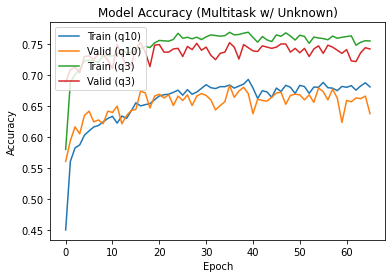

In [294]:
plt.plot(history.history['q10_acc'])
plt.plot(history.history['val_q10_acc'])
plt.plot(history.history['q3_acc'])
plt.plot(history.history['val_q3_acc'])
plt.title('Model Accuracy (Multitask w/ Unknown)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q3)', 'Valid (q3)'], loc='upper left')
plt.show()

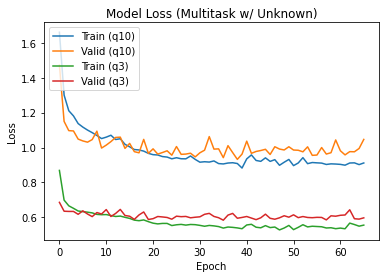

In [295]:
plt.plot(history.history['q10_loss'])
plt.plot(history.history['val_q10_loss'])
plt.plot(history.history['q3_loss'])
plt.plot(history.history['val_q3_loss'])
plt.title('Model Loss (Multitask w/ Unknown)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q3)', 'Valid (q3)'], loc='upper left')
plt.show()

In [296]:
model.evaluate(test_df, [to_categorical(test_lab_loc_u), to_categorical(test_lab_mem_u)])

2456/2456 [==============================] - 0s 32us/step


[1.834150211042224,
 1.1770422695514045,
 0.6571079447914024,
 0.6038273615635179,
 0.6038273615635179,
 0.727198696874252,
 0.727198696874252]

#### Multitask (Masked Loss Function)

In [ ]:
id_dict_mem_masked = {
    'M': 0,
    'S': 1,
    'U': -1
}

In [ ]:
# Create new label lists with ints instead of strings
train_lab_loc_u = [id_dict[label] for label in train_loc_labels_mtu]
valid_lab_loc_u = [id_dict[label] for label in valid_loc_labels_mtu]
test_lab_loc_u = [id_dict[label] for label in test_loc_labels_mtu]

train_lab_mem_u = [id_dict_mem[label] for label in train_mem_labels_mtu]
valid_lab_mem_u = [id_dict_mem[label] for label in valid_mem_labels_mtu]
test_lab_mem_u = [id_dict_mem[label] for label in test_mem_labels_mtu]

In [298]:
from keras import backend as K

mask_value = -1

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [308]:
keras.backend.clear_session()

visible = keras.Input(shape=(768,))
# h1 = Dense(32, activation='relu')(visible)
# h2 = Dropout(0.25)(h1)
# hf = BatchNormalization()(h2)

h1 = Dense(32, activation='relu')(visible)
hf = Dense(32, activation='relu')(h1)

output_q10 = Dense(10, activation='softmax', name='q10')(hf)
output_q2 = Dense(3, activation='softmax', name='q2')(hf)

model = keras.Model(inputs=visible, outputs=[output_q10, output_q2])
model.compile(loss=['categorical_crossentropy', masked_loss_function],
              optimizer='adam', metrics=['accuracy', 'accuracy'])

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001)
]

history = model.fit(train_df,
                    [to_categorical(train_lab_loc_u), to_categorical(train_lab_mem_u)],
                    validation_data=(valid_df, [to_categorical(valid_lab_loc_u), to_categorical(valid_lab_mem_u)]),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Train on 9099 samples, validate on 989 samples
Epoch 1/200
9099/9099 [==============================] - 1s 122us/step - loss: 1.9980 - q10_loss: 1.5217 - q2_loss: 0.4763 - q10_acc: 0.4720 - q10_acc_1: 0.4720 - q2_acc: 0.6364 - q2_acc_1: 0.6364 - val_loss: 1.7239 - val_q10_loss: 1.2853 - val_q2_loss: 0.4386 - val_q10_acc: 0.5399 - val_q10_acc_1: 0.5399 - val_q2_acc: 0.6714 - val_q2_acc_1: 0.6714
Epoch 2/200
9099/9099 [==============================] - 0s 47us/step - loss: 1.5835 - q10_loss: 1.1819 - q2_loss: 0.4016 - q10_acc: 0.5834 - q10_acc_1: 0.5834 - q2_acc: 0.7006 - q2_acc_1: 0.7006 - val_loss: 1.5320 - val_q10_loss: 1.1283 - val_q2_loss: 0.4037 - val_q10_acc: 0.5794 - val_q10_acc_1: 0.5794 - val_q2_acc: 0.6876 - val_q2_acc_1: 0.6876
Epoch 3/200
9099/9099 [==============================] - 0s 42us/step - loss: 1.4687 - q10_loss: 1.0859 - q2_loss: 0.3828 - q10_acc: 0.6173 - q10_acc_1: 0.6173 - q2_acc: 0.7181 - q2_acc_1: 0.7181 - val_loss: 1.4307 - val_q10_loss: 1.0411 - val_q2_loss:

9099/9099 [==============================] - 0s 44us/step - loss: 0.9895 - q10_loss: 0.6947 - q2_loss: 0.2948 - q10_acc: 0.7615 - q10_acc_1: 0.7615 - q2_acc: 0.7981 - q2_acc_1: 0.7981 - val_loss: 1.3074 - val_q10_loss: 0.9282 - val_q2_loss: 0.3791 - val_q10_acc: 0.6835 - val_q10_acc_1: 0.6835 - val_q2_acc: 0.7199 - val_q2_acc_1: 0.7199
Epoch 25/200
9099/9099 [==============================] - 0s 45us/step - loss: 0.9725 - q10_loss: 0.6778 - q2_loss: 0.2947 - q10_acc: 0.7650 - q10_acc_1: 0.7650 - q2_acc: 0.7999 - q2_acc_1: 0.7999 - val_loss: 1.2702 - val_q10_loss: 0.8961 - val_q2_loss: 0.3741 - val_q10_acc: 0.6967 - val_q10_acc_1: 0.6967 - val_q2_acc: 0.7300 - val_q2_acc_1: 0.7300
Epoch 26/200
9099/9099 [==============================] - 0s 43us/step - loss: 0.9560 - q10_loss: 0.6681 - q2_loss: 0.2878 - q10_acc: 0.7669 - q10_acc_1: 0.7669 - q2_acc: 0.8015 - q2_acc_1: 0.8015 - val_loss: 1.2938 - val_q10_loss: 0.9172 - val_q2_loss: 0.3766 - val_q10_acc: 0.6946 - val_q10_acc_1: 0.6946 - va

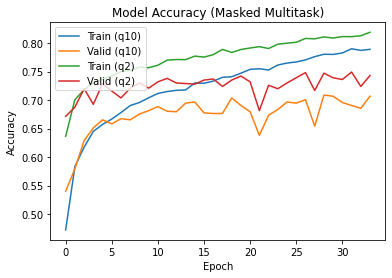

In [309]:
plt.plot(history.history['q10_acc'])
plt.plot(history.history['val_q10_acc'])
plt.plot(history.history['q2_acc'])
plt.plot(history.history['val_q2_acc'])
plt.title('Model Accuracy (Masked Multitask)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

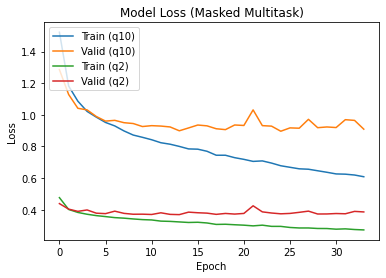

In [310]:
plt.plot(history.history['q10_loss'])
plt.plot(history.history['val_q10_loss'])
plt.plot(history.history['q2_loss'])
plt.plot(history.history['val_q2_loss'])
plt.title('Model Loss (Masked Multitask)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

In [311]:
model.evaluate(test_df, [to_categorical(test_lab_loc_u), to_categorical(test_lab_mem_u)])

2456/2456 [==============================] - 0s 24us/step


[1.468744568017096,
 1.0557510893585627,
 0.4129934799205208,
 0.6620521174579956,
 0.6620521174579956,
 0.7259771985029164,
 0.7259771985029164]

#### Subcellular Location w/ Smaller Dataset

In [262]:
keras.backend.clear_session()

visible = keras.Input(shape=(768,))
h1 = Dense(32, activation='relu')(visible)
h2 = Dense(32, activation='relu')(h1)

output_q10 = Dense(10, activation='softmax', name='q10')(h2)

model = keras.Model(inputs=visible, outputs=output_q10)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

history = model.fit(train_df_mt, to_categorical(train_lab_loc),
                    validation_data=(valid_df_mt, to_categorical(valid_lab_loc)),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Train on 5726 samples, validate on 620 samples
Epoch 1/200
5726/5726 [==============================] - 1s 92us/step - loss: 1.4511 - acc: 0.5648 - val_loss: 1.1821 - val_acc: 0.6613
Epoch 2/200
5726/5726 [==============================] - 0s 36us/step - loss: 1.1048 - acc: 0.6584 - val_loss: 1.0385 - val_acc: 0.6774
Epoch 3/200
5726/5726 [==============================] - 0s 41us/step - loss: 0.9831 - acc: 0.6851 - val_loss: 0.9348 - val_acc: 0.6984
Epoch 4/200
5726/5726 [==============================] - 0s 41us/step - loss: 0.9205 - acc: 0.6987 - val_loss: 0.9123 - val_acc: 0.7016
Epoch 5/200
5726/5726 [==============================] - 0s 36us/step - loss: 0.8643 - acc: 0.7202 - val_loss: 0.8726 - val_acc: 0.7194
Epoch 6/200
5726/5726 [==============================] - 0s 42us/step - loss: 0.8324 - acc: 0.7297 - val_loss: 0.8633 - val_acc: 0.7161
Epoch 7/200
5726/5726 [==============================] - 0s 40us/step - loss: 0.7922 - acc: 0.7515 - val_loss: 0.8223 - val_acc: 0.7323
E

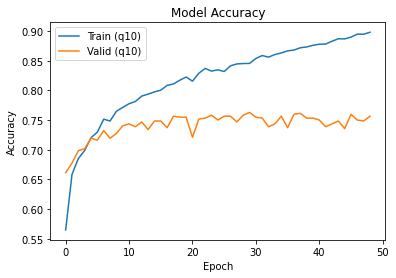

In [264]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)'], loc='upper left')
plt.show()

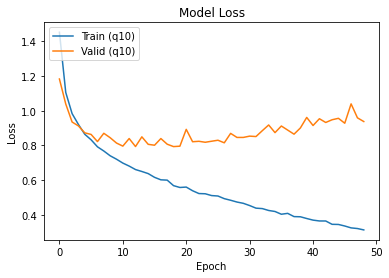

In [265]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)'], loc='upper left')
plt.show()

In [266]:
model.evaluate(test_df_mt, to_categorical(test_lab_loc))

1565/1565 [==============================] - 0s 71us/step


[1.1169203719391991, 0.7137380189788989]